# Convolutional Neural Networks

### Notebook Imports

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Unzipping Files from train.zip, test.zip

In [2]:
os.makedirs('/kaggle/working/train')
os.makedirs('/kaggle/working/test')

In [3]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [4]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working/train

In [5]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [6]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working/test

### Data Preparation

In [7]:
os.chdir('/kaggle/working/')

if os.path.isdir('train_set/dog') is False:
    os.makedirs('train_set/dog')
    os.makedirs('train_set/cat')
    os.makedirs('valid_set/dog')
    os.makedirs('valid_set/cat')
    os.makedirs('test_set/cat')
    os.makedirs('test_set/dog')
    
    try:
        for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 500):
            shutil.move(c, 'train_set/cat')
        for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 500):
            shutil.move(c, 'train_set/dog')
        for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 100):
            shutil.move(c, 'valid_set/cat')
        for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 100):
            shutil.move(c, 'valid_set/dog')
        for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 50):
            shutil.move(c, 'test_set/cat')
        for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 50):
            shutil.move(c, 'test_set/dog')

    except Exception as e:
        print(f"An error occurred: {e}")

os.chdir('../..')

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

In [9]:
folder_path = '/kaggle/working/train'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

folder_path = '/kaggle/working/test'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

### Constants

In [10]:
train_set = "/kaggle/working/train_set"
test_set = "/kaggle/working/test_set"
valid_set = "/kaggle/working/valid_set"

### Build and Train a CNN

In [11]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_set, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_set, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_set, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [12]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [13]:
imgs, labels = next(train_batches)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

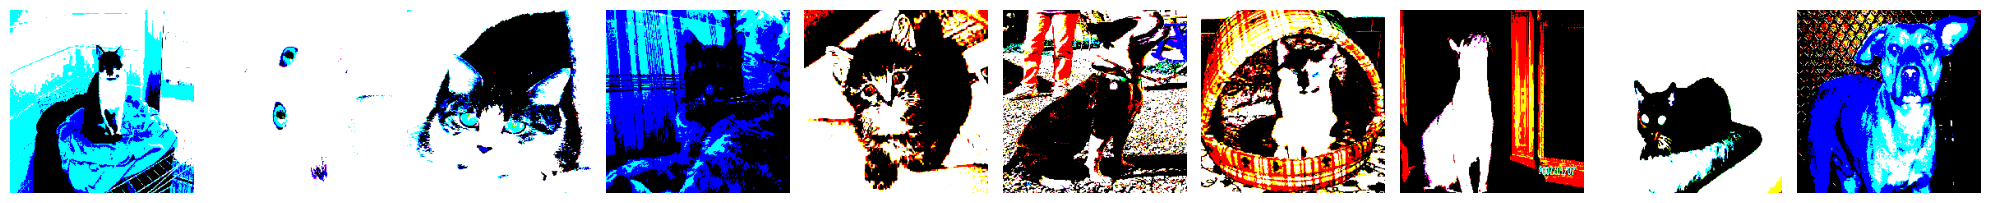

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [15]:
plotImages(imgs)
print(labels)

In [16]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches,
          validation_steps=len(valid_batches), epochs=10, verbose=2
)

Epoch 1/10
100/100 - 7s - loss: 31.0572 - accuracy: 0.5570 - val_loss: 17.3505 - val_accuracy: 0.5500 - 7s/epoch - 66ms/step
Epoch 2/10
100/100 - 3s - loss: 11.2424 - accuracy: 0.7220 - val_loss: 16.8964 - val_accuracy: 0.6250 - 3s/epoch - 29ms/step
Epoch 3/10
100/100 - 3s - loss: 6.1781 - accuracy: 0.8080 - val_loss: 14.1169 - val_accuracy: 0.6050 - 3s/epoch - 30ms/step
Epoch 4/10
100/100 - 3s - loss: 3.0081 - accuracy: 0.8600 - val_loss: 13.6712 - val_accuracy: 0.5700 - 3s/epoch - 30ms/step
Epoch 5/10
100/100 - 3s - loss: 1.7596 - accuracy: 0.8970 - val_loss: 13.9001 - val_accuracy: 0.5900 - 3s/epoch - 30ms/step
Epoch 6/10
100/100 - 3s - loss: 0.6131 - accuracy: 0.9450 - val_loss: 16.6008 - val_accuracy: 0.5600 - 3s/epoch - 30ms/step
Epoch 7/10
100/100 - 3s - loss: 0.7082 - accuracy: 0.9450 - val_loss: 14.0987 - val_accuracy: 0.6200 - 3s/epoch - 29ms/step
Epoch 8/10
100/100 - 3s - loss: 0.7091 - accuracy: 0.9550 - val_loss: 12.2437 - val_accuracy: 0.5900 - 3s/epoch - 30ms/step
Epoch 

### CNN Predictions

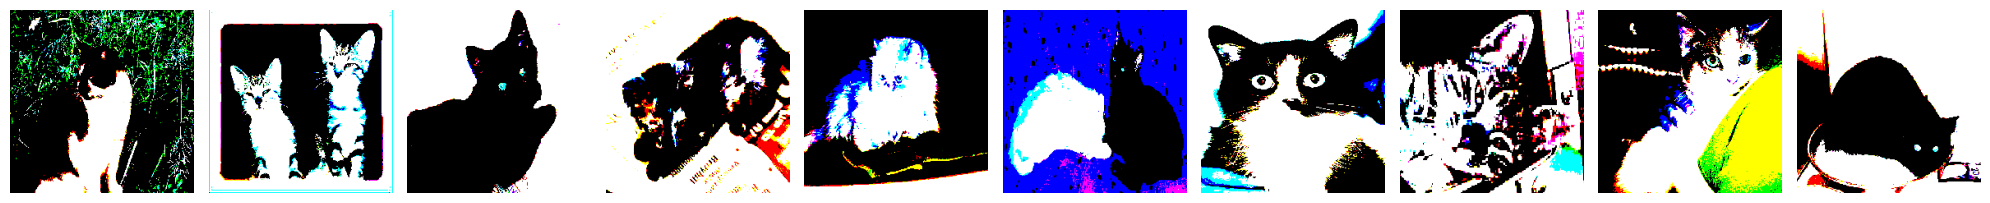

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [20]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [21]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [24]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [25]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion Matrix, without normalization")
        
    print(cm)
    
    tresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                color='white' if cm[i, j] > tresh else "black")
        
        plt.tight_layout()
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")

In [26]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion Matrix, without normalization
[[27 23]
 [22 28]]


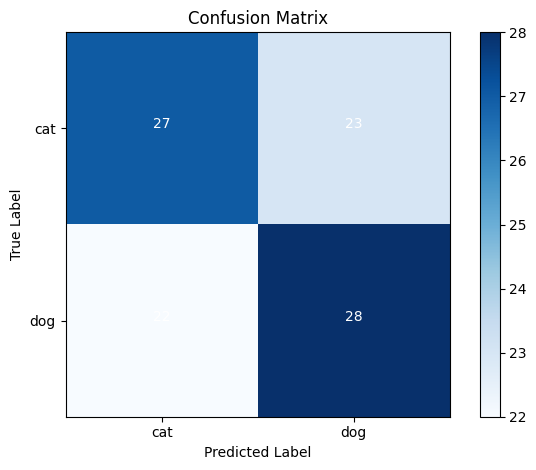

In [27]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')